In [1]:
import gym
from gym import spaces
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

In [150]:
class EnvTest(gym.Env):
    def __init__(self, balance=100, spread=0.05, max_variation=0.00005, simulation_duration="10", nb_stock=10):
        self.spread = spread # valeur du spread
        self.max_variation = max_variation # variation maximale de la courbe en pourcentage
        self.simulation_duration = simulation_duration # durée de la simulation demandées
        self.nb_stock = nb_stock
        self.text = False
        self.action_spaces = spaces.Discrete(3) # 0 = achat, 1 = nothing, 2 = vendre
        self.observation_spaces = spaces.Box(low=-np.inf,
                                           high=np.inf,
                                           shape=(2,),
                                           dtype=np.float32)
        
        self.starting_balance = balance # valeur du porte feuille
        self.timestep = 1.0 # simulation sur un pas de 1 seconde
        self.max_time = self.timeConverter(self.simulation_duration) # temps maximum d'un épisode
        
        np.set_printoptions(precision=5)
        self.reset()
        print(f"Balance : {self.balance} - spread : {(self.spread*100)}%")
        
    def step(self, action):
        """effectue un 'step' dans la simulation"""
        
        if self.current_time >= self.max_time:
            self.done = True
        self.current_time += self.timestep
        
        self.checkPos(action)
        self.saveBalanceData()
        self.generateCurveData()
        self.setObservations()       
        return self.next_state, self.reward, self.done, self.info
    
                      
    def reset(self):
        """Reinitialise les variables modifiable"""
        self.balance = self.starting_balance
        self.curve_values = [] 
        self.balance_values = [self.balance]
        self.current_curve_value = self.initializeCurve()
        self.profit_loss = 0.0
        
        self.current_time = 0.0
        self.reward = 0.0
        self.done = False
        self.info = {}
        
        self.state = np.zeros(self.observation_spaces.shape[0])
        self.next_state = self.state
        last_action = 1 # derniere action effectué par l'agent, initialisé à 1 "nothing"
        self.last_buy_or_sell_value = False # valeur de la courbe lors de l'achat ou de la vente
        
        self.pos = "Pas de position"        
        
        return self.next_state, self.reward, self.done, self.info
    
        
    def render(self):
        """Affiche l'environnement, dans notre cas la courbe"""
        #print(f"balance historique : {self.balance_values}")
        fig, axes = plt.subplots(2,1, figsize = (12, 5), dpi = 200)
        fig.subplots_adjust(hspace=0.3) 

        axes[0].plot(self.curve_values)
        axes[0].set_ylabel("EUR/USD")
        axes[0].set_title("EUR/USD simulé*")
        axes[1].plot(self.balance_values)
        axes[1].set_ylabel("EUR")
        axes[1].set_title("Valeur du porte-feuille")
        axes[1].set_xlabel("Secondes")
        
    def initializeCurve(self):
        """Initialise une courbe entre les valeurs min et max"""
        minimum_value = 1.053
        maximum_value = 1.062
        value = rnd.uniform(minimum_value, maximum_value)
        self.curve_values.append(value)
        return value
    
    def generateCurveData(self):
        """génère la prochaine valeur de la courbe en fonction du taux de variation
        sauvegarde la valeur dans l'historique"""
        variation = rnd.uniform(-self.max_variation, self.max_variation)
        self.current_curve_value += self.current_curve_value * variation
        self.saveCurveData()
    
    def saveCurveData(self):
        """Sauvegarde les données de la courbe dans une liste"""
        self.curve_values.append(self.current_curve_value)

    def saveBalanceData(self):
        """Sauvegarde les données du porte feuille dans une liste"""
        self.balance_values.append(self.balance)
        
    def updateProfitAndLoss(self, action):
        if self.last_buy_or_sell == False: # Si l'agent n'a jamais acheté ou vendu
            return 0.0
    
    def setObservations(self):
        """Gestion des observations"""
        self.next_state[0] = self.curve_values[-1] ## Valeur actuelle de la courbe/last value de l'histo
        self.next_state[1] = self.profit_loss ## Valeur actuelle des profits/pertes
              
    def setReward(self):
        """Gestion des rewards"""
        pass
    
    def checkPos(self, action):
        if action == 0:
            if self.pos == "Pas de position":
                if self.checkActionCostCalculation(action):
                    if self.text:
                        print(f"Achat de {self.nb_stock} stocks à {self.current_curve_value}")
                        print(f"Current balance : {self.balance}")
                        print()
                    self.pos = "Achat"
                    self.last_action = 0
                    self.last_buy_or_sell_value = self.current_curve_value
            elif self.pos == "Vente":
                if self.text: print(f"Fin de la position de vente de {self.nb_stock} stocks à {self.last_buy_or_sell_value}")
                self.checkActionGainCalculation(action)
                self.pos = "Pas de position"
                self.last_action = 0
                self.last_buy_or_sell_value = False
            else:
                self.last_action = 0

        if action == 2:
            if self.pos == "Pas de position":
                if self.checkActionCostCalculation(action):
                    if self.text:
                        print(f"Vente de {self.nb_stock} stocks à {self.current_curve_value}")
                        print(f"Current balance : {self.balance}")
                        print()
                    self.pos = "Vente"
                    self.last_action = 2
                    self.last_buy_or_sell_value = self.current_curve_value
            elif self.pos == "Achat":
                if self.text: print(f"Fin de la position d'achat de {self.nb_stock} stocks à {self.last_buy_or_sell_value}")
                self.checkActionGainCalculation(action)
                self.pos = "Pas de position"
                self.last_action = 2
                self.last_buy_or_sell_value = False
            else:
                self.last_action = 2

        if action == 1:
            self.last_action = 1
    
    def checkActionCostCalculation(self, action):
        if action == 0 or action == 2:
            if self.balance > ((2*self.nb_stock) * self.current_curve_value):
                self.balance -= (self.nb_stock * self.current_curve_value) + ((1 + self.spread) * self.current_curve_value)   
                return True
            else:
                print("Fonds insuffisant...")
                return False

    def checkActionGainCalculation(self, action):
        if action == 0 or action == 2:
            self.balance += (self.nb_stock * self.current_curve_value)
            
            if (self.nb_stock * self.current_curve_value) >= 0:              
                if self.text : print(f"Balance : +{(self.nb_stock * self.current_curve_value)}g")
            else:
                if self.text : print(f"Balance : -{(self.nb_stock * self.current_curve_value)}g")
                #print()
    
    def timeConverter(self, time):
        """Convertie la durée entrée manuellement
        Renvois la durée maximale en seconde (ou en fonction du time step)"""
        number = ""
        value = ""
        for string in time:
            if string.isdigit():
                number += string
            else:
                value += string

        if not self.translate(value):
            print("Durée de simulation incorrect...")
            exit() # ajouter la gestion de mauvaises données
        time_converted = int(number) * self.translate(value)
        return time_converted
    
    def translate(self, value):
        """fonction qui permet de traduire et la renvoie en seconde"""
        
        ## Constantes de temps en secondes
        SECONDE = 1.0
        MINUTE = 60.0
        HOUR = 60.0 * MINUTE
        DAY = 24.0 * HOUR
        WEEK = 7.0 * DAY
        MONTH = 30.0 * DAY
        YEAR = 365.0 * DAY
        
        d = {"seconde" : ["s", "seconde", "secondes", "sec", "secs"],
            "minute" : ["m", "min", "minute", "minutes", "mins", "minutes"],
            "hour" : ["h", "heure", "hour", "hours", "heures"],
            "day" : ["d", "j", "jour", "day", "jours"],
            "week" : ["w", "week", "semaine", "weeks", "semaines"],
            "year" : ["y", "year", "année", "annee", "an", "années", "years"]
            }

        for key in d.keys():
            if value.lower() in key:
                if key == "seconde":
                    return SECONDE
                elif key == "minute":
                    return MINUTE
                elif key == "hour":
                    return HOUR
                elif key == "day":
                    return DAY
                elif key == "week":
                    return WEEK
                elif key == "year":
                    return YEAR
                
        return False

    
class Agent():
    def __init__(self):
        pass
    
    def act(self):
        pass

Balance : 100 - spread : 5.0%
env observation spaces : (2,)
env action spaces : 3



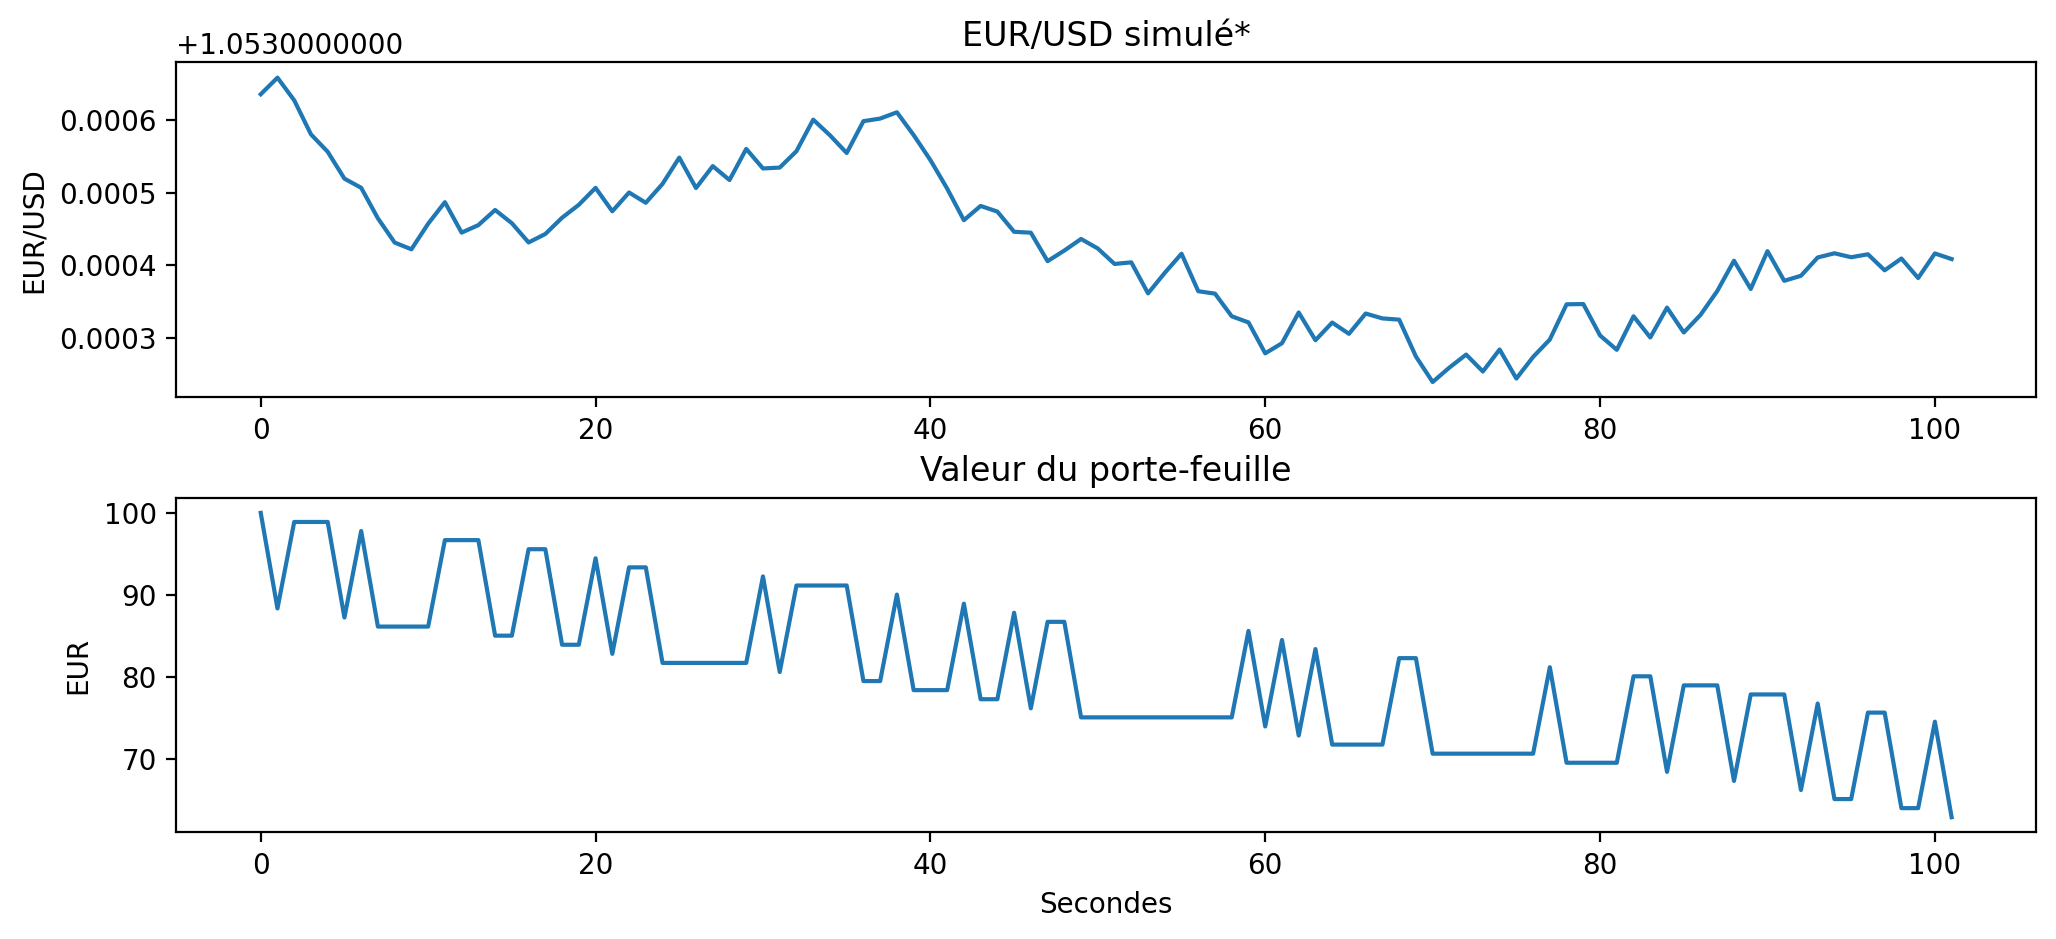

In [151]:
env = EnvTest(simulation_duration="100")
agent = Agent()
print(f"env observation spaces : {env.observation_spaces.shape}")
print(f"env action spaces : {env.action_spaces.n}")
print()
num_action = env.action_spaces.n
num_observation = env.observation_spaces.shape[0]

nb_max_episode = 1

for episode in range(nb_max_episode):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        action = env.action_spaces.sample()
        next_state, reward, done, _ = env.step(action)
        #print(f"episode : {episode+1} - score total : {score}")
        
        score += reward
        state = next_state
        
        if done:
            env.render()
            #print(f"episode : {episode+1} - score total : {score}")
            pass

In [ ]:
# ajouter une fois l'env entièrement débuggé
import random
import time

# Define initial price and volatility
price = 1.2
volatility = 0.01/100


# Define a function to update the volatility each minute
def update_volatility():
    return random.uniform(0.005, 0.02/100)


# Define a function to calculate the jump size based on jump diffusion model
def jump_diffusion():
    lambda_j = 0.001
    mu_j = -0.1/5
    sigma_j = 0.1/100
    jump = 0
    if random.uniform(0, 1) < lambda_j:
        jump = random.normalvariate(mu_j, sigma_j)
    return jump


# Simulate prices for one day
for i in range(24 * 60 * 60):
    # Calculate the next price as a random walk with jumps
    jump = jump_diffusion()
    volatility = update_volatility()
    price += random.normalvariate(0, volatility) + jump
    # Print the current time and price
    print(time.strftime("%Y-%m-%d %H:%M:%S"), round(price, 6))
    # Wait for one second
    time.sleep(1)

In [ ]:
import csv
from datetime import datetime, timedelta
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

class MarketDataApp(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.order_book = {}

    def error(self, reqId, errorCode, errorString):
        print("Error {}: {}".format(errorCode, errorString))

    def historicalData(self, reqId, bar):
        if bar.date[-8:] == "16:00:00":
            if "BID" not in self.order_book:
                self.order_book["BID"] = {}
            if "ASK" not in self.order_book:
                self.order_book["ASK"] = {}
            self.order_book["BID"][bar.open] = bar.volume
            self.order_book["ASK"][bar.close] = bar.volume

    def get_order_book(self, filename):
        contract = Contract()
        contract.symbol = "EUR"
        contract.secType = "CFD"
        contract.currency = "USD"
        contract.exchange = "SMART"
        end_time = datetime(year=2023, month=2, day=24, hour=14, minute=0, second=0)
        start_time = end_time - timedelta(minutes=1)
        end_time_str = end_time.strftime("%Y%m%d-%H:%M:%S")
        self.reqHistoricalData(1, contract, end_time_str, "1 day", "1 hour", "BID", 1, 1, False, [])
        self.run()
        self.print_order_book(filename)

    def print_order_book(self, filename):
        if not self.order_book:
            print("Error: order book data not available")
            return
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['BID Size', 'Price', 'ASK Size'])
            for price in sorted(self.order_book["BID"], reverse=True):
                bid_size = self.order_book["BID"][price]
                if price in self.order_book["ASK"]:
                    ask_size = self.order_book["ASK"][price]
                else:
                    ask_size = "-"
                writer.writerow([bid_size, price, ask_size])


app = MarketDataApp()
app.connect("127.0.0.1", 7496, 0)
app.get_order_book("eurusd_order_book.csv")
app.disconnect()
